In [231]:
import pandas as pd
data=pd.read_csv('Data.csv')
print(data)
print(data.shape)

                                                Reviews     label
0     Okay, so I'm not a big video game buff, but wa...  negative
1     The premise of this movie has been tickling my...   postive
2     Jim Carrey is back to much the same role that ...   postive
3     I read several mixed reviews and several of th...   postive
4     Warning: Does contain spoilers.<br /><br />Ope...   postive
...                                                 ...       ...
7495  It was great to see some of my favorite stars ...  negative
7496  2 stars for Kay Francis -- she's wonderful! An...  negative
7497  I really wish i could give this a negative vot...  negative
7498  I love B movies..but come on....this wasn't ev...  negative
7499  As I said in my comment about the first part: ...   postive

[7500 rows x 2 columns]
(7500, 2)


In [232]:
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
import contractions
import swifter

def tosentences(article):
    sentences=article.split(". ")
    sentences=[sentence.strip() for sentence in sentences]
    return sentences

In [233]:
data['sentence']=data['Reviews'].swifter.apply(tosentences)

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

In [237]:
def preprocess(sentences, min_word_length=2):
    preprocessed_sentences = []
    for sentence in sentences:
        soup = BeautifulSoup(sentence, 'html.parser')
        sentence = soup.get_text()
        sentence = contractions.fix(sentence)
        words = word_tokenize(sentence)
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word.lower() not in stop_words]
        words = [re.sub(r'\d+', '', word) for word in words]  
        words = [re.sub(r'\d', '', word) for word in words]   
        words = [re.sub(r'(.)\1+', r'\1\1', word) for word in words] 
        words = [re.sub(r'\{.*?\}', '', word) for word in words] 
        words = [re.sub(r'^[\'\s]*|[^\w\s\'-]', '', word) for word in words] 
        words = [re.sub(r'\.{3,}', '', word) for word in words]  
        words = [re.sub(r'\.{4,}', '', word) for word in words]  
        words = [re.sub(r'\.( +)', '.', word) for word in words] 
        words = [word for word in words if len(word) >= min_word_length and not word.isnumeric() and word not in string.punctuation]
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
        preprocessed_sentence = ' '.join(words)
        preprocessed_sentences.append(preprocessed_sentence)
    
    return preprocessed_sentences

In [238]:
data['processed'] = data['sentence'].swifter.apply(preprocess)

Pandas Apply:   0%|          | 0/7500 [00:00<?, ?it/s]

C:\Users\akvnr\AppData\Local\Temp\ipykernel_14224\1479389325.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence, 'html.parser')


In [239]:
data['processed'][0]

['Okay big video game buff game House Dead really famous enough make movie Sure went far actually put quick video game clip throughout movie though justifying particular scene violence dozen dozen game look exactly hand bottom screen supposedly holding whatever weapon goo-ing kind alien walking dead sniper whatever case may beIt interesting premise House Dead lot college kid LOADED college kid kid able pay fisherman something like ride miss boat trying get island supposed rave year',
 'first thing come mind House Dead watching become increasingly clear modern horror movie become nothing exercise coming creative way get lot scantily clad teenager exactly situation',
 'least case fact way rave excuse way girl dressed',
 'look badly place running around wood cute little halter-tops least THOUGHT dressed occasionClint Howard tellingly interesting character film far delivers absolutely awful performance greatness overshadows every actor movie',
 'stand well-known actor change accent movie r

In [240]:
def wordtokenize(sentences):
    tokenized_sentences = []
    for sentence in sentences:
        words = word_tokenize(sentence.lower())
        tokenized_sentences.append(words)
    return tokenized_sentences

In [241]:
data['tok']=data['processed'].apply(wordtokenize)

In [ ]:
import numpy as np
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string


def Iterative(row,c=1):
    num_runs=6
    num_topics=5
    tokenized_sentences = [word_tokenize(sentence) for sentence in row['processed']]
    dictionary = Dictionary(tokenized_sentences)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_sentences]
    coherence_scores = []
    lda_models = []
    t = []
    for i in range(num_runs):
        t.append(num_topics)
        lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        coherence_model = CoherenceModel(model=lda_model, texts=tokenized_sentences, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        lda_models.append(lda_model)
        num_topics += 1
        
    best_model_index = np.argmax(coherence_scores)
    best_model = lda_models[best_model_index]
    
    topic_words_list = []
    for idx, topic in best_model.print_topics(-1):
        topic_words = [word.split('"')[1] for word in topic.split()[1:] if '"' in word]
        topic_words_list.append(topic_words)
    print(c,end=' ')
    sentence_topic_distributions = []
    for doc in corpus:
        sentence_topic_distribution = best_model.get_document_topics(doc)
        sentence_topic_distributions.append(dict(sentence_topic_distribution))    
    row['topic_words'] = topic_words_list
    row['sentence_topic_distributions'] = sentence_topic_distributions
    row['T'] = t
    row['CS'] = coherence_scores
    return row

In [ ]:
import time
from datetime import datetime
start_time = time.time()
Iter=Iter.apply(Iterative,axis=1)
end_time = time.time()
execution_time_seconds=end_time - start_time
execution_time_formatted = execution_time_seconds/60
print("Execution Time:", execution_time_formatted)

In [1]:
import pandas as pd
Iter=pd.read_csv('TSDA1.csv')

In [2]:
Iter

,Reviews,label,sentence,processed,tok,topic_words,sentence_topic_distributions,T,CS
0,"Okay, so I'm not a big video game buff, but wa...",negative,"[""Okay, so I'm not a big video game buff, but ...",['Okay big video game buff game House Dead rea...,"[['okay', 'big', 'video', 'game', 'buff', 'gam...","[['well-known', 'Sure', 'movie', 'something', ...","[{1: 0.9545177, 4: 0.03509016}, {7: 0.96665996...","[5, 6, 7, 8, 9, 10]","[0.4583729995310059, 0.334587069025875, 0.3904..."
1,The premise of this movie has been tickling my...,postive,['The premise of this movie has been tickling ...,['premise movie tickling imagination quite tim...,"[['premise', 'movie', 'tickling', 'imagination...","[['movie', 'like', 'story', 'Nothing', 'extrem...","[{0: 0.014288956, 1: 0.014285956, 2: 0.0142859...","[5, 6, 7, 8, 9, 10]","[0.3372027356528349, 0.33957990065147653, 0.34..."
2,Jim Carrey is back to much the same role that ...,postive,['Jim Carrey is back to much the same role tha...,['Jim Carrey back much role played Mask timid ...,"[['jim', 'carrey', 'back', 'much', 'role', 'pl...","[['comedy', 'nice', 'see', 'cheesy', 'definite...","[{5: 0.95061326}, {5: 0.9477094}, {8: 0.931618...","[5, 6, 7, 8, 9, 10]","[0.4738946513467172, 0.4727621906821173, 0.386..."
3,I read several mixed reviews and several of th...,postive,['I read several mixed reviews and several of ...,['read several mixed review several downright ...,"[['read', 'several', 'mixed', 'review', 'sever...","[['lot', 'movie', 'give', 'Scott', 'people', '...","[{0: 0.011111938, 1: 0.01111126, 2: 0.01111146...","[5, 6, 7, 8, 9, 10]","[0.36906453003518147, 0.32832384974819934, 0.3..."
4,Warning: Does contain spoilers.<br /><br />Ope...,postive,['Warning: Does contain spoilers.<br /><br />O...,['Warning contain spoilersOpen EyesIf seen fil...,"[['warning', 'contain', 'spoilersopen', 'eyesi...","[['craze', 'Julie', 'play', 'good', 'character...","[{0: 0.013890208, 1: 0.013897444, 2: 0.0139040...","[5, 6, 7, 8, 9, 10]","[0.3995085302800798, 0.4099410207385928, 0.369..."
...,...,...,...,...,...,...,...,...,...
495,"The key to the joy and beauty, the pain and sa...",postive,"[""The key to the joy and beauty, the pain and ...",['key joy beauty pain sadness life ability acc...,"[['key', 'joy', 'beauty', 'pain', 'sadness', '...","[['played', 'yet', 'fable', 'beautiful', 'well...","[{5: 0.94531196}, {0: 0.041666806, 1: 0.041666...","[5, 6, 7, 8, 9, 10]","[0.4987844245355492, 0.4893576390582497, 0.508..."
496,This film started out very promising with the ...,negative,['This film started out very promising with th...,['film started promising story director loses ...,"[['film', 'started', 'promising', 'story', 'di...","[['ship', 'know', 'character', 'somewhere', 'H...","[{0: 0.013898993, 1: 0.013907761, 2: 0.0139031...","[5, 6, 7, 8, 9, 10]","[0.5161691232150755, 0.6296543045345957, 0.516..."
497,This film is one of the best shorts I've ever ...,postive,['This film is one of the best shorts I\'ve ev...,['film one best short ever seen make point maj...,"[['film', 'one', 'best', 'short', 'ever', 'see...","[['engaging', 'award', 'people', 'script', 'li...","[{2: 0.051776588, 6: 0.9124676}, {0: 0.0109891...","[5, 6, 7, 8, 9, 10]","[0.5751657189619286, 0.43900857778711716, 0.60..."
498,I am amazed at the amount of praise that is he...,negative,['I am amazed at the amount of praise that is ...,['amazed amount praise heaped movie commentato...,"[['amazed', 'amount', 'praise', 'heaped', 'mov...","[['Republic', 'Campbell', 'Jr', 'wife', 'story...","[{0: 0.0142862145, 1: 0.014286415, 2: 0.014285...","[5, 6, 7, 8, 9, 10]","[0.40678453470555914, 0.4187965512943764, 0.40..."


x shape: 6
y shape: 6


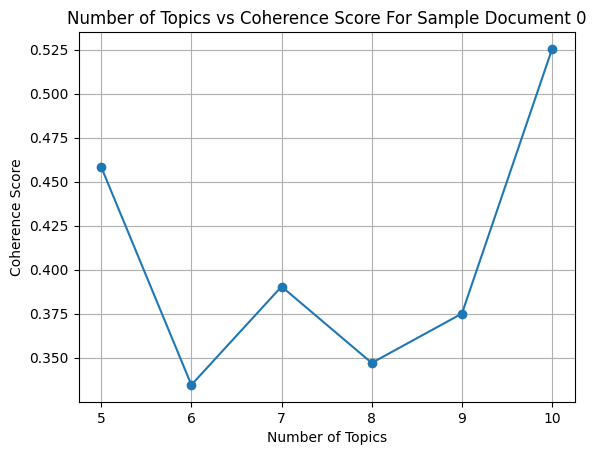

x shape: 6
y shape: 6


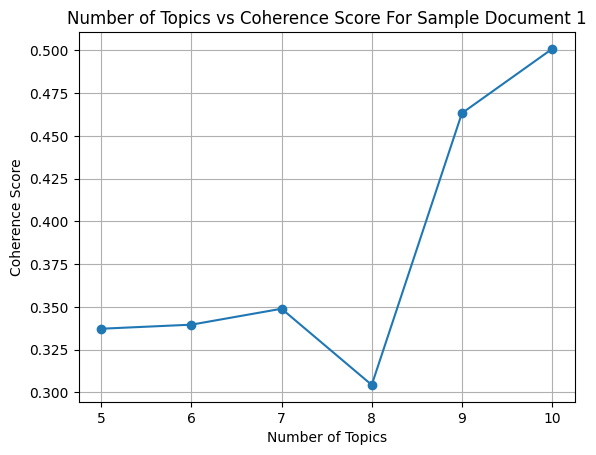

x shape: 6
y shape: 6


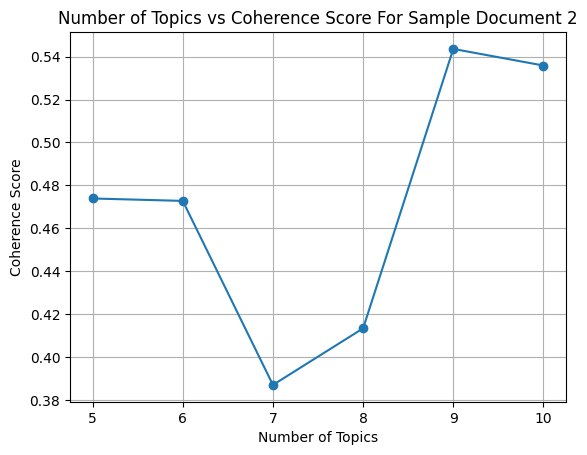

In [3]:
import matplotlib.pyplot as plt

def plotnc(x, y, i):
    if isinstance(x, str):
        x = eval(x)
    if isinstance(y, str):
        y = eval(y)
    x = [int(val) for val in x]
    y = [float(val) for val in y]
    print("x shape:", len(x))  
    print("y shape:", len(y)) 
    plt.plot(x, y, marker='o', linestyle='-')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.title('Number of Topics vs Coherence Score For Sample Document ' + str(i))
    plt.grid(True)
    plt.show()

for i in range(3):
    x_values = Iter['T'][i] 
    y_values = Iter['CS'][i]
    plotnc(x_values, y_values, i)


In [4]:
import ast
import swifter

def filter_topic_distribution(topic_distribution_list):
    theta = 0.1
    t1_list = []
    distribution_list = ast.literal_eval(topic_distribution_list)
    for distribution in distribution_list:
        filtered_distribution = [{k: v} for k, v in distribution.items() if v > theta]
        t1_list.extend(filtered_distribution)
    return t1_list

Iter['DTC'] = Iter['sentence_topic_distributions'].swifter.apply(filter_topic_distribution)

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

In [5]:
Iter['DTC'][0]

[{1: 0.9545177},
 {7: 0.96665996},
 {2: 0.90999764},
 {4: 0.9689605},
 {0: 0.96249825},
 {3: 0.774996},
 {0: 0.9249976},
 {6: 0.95908606},
 {8: 0.9181775},
 {3: 0.899998},
 {6: 0.97272474},
 {4: 0.9808503},
 {4: 0.94705486},
 {5: 0.8999953},
 {9: 0.94705623},
 {0: 0.7749911},
 {4: 0.9181777},
 {5: 0.9816315},
 {9: 0.9549979},
 {6: 0.6999948},
 {6: 0.9437475},
 {4: 0.5082871},
 {6: 0.46590003},
 {1: 0.96249866},
 {5: 0.9549975},
 {6: 0.97096187},
 {2: 0.957142},
 {8: 0.9639977},
 {4: 0.31202573},
 {8: 0.5546321},
 {8: 0.9549978},
 {9: 0.95499074}]

In [6]:
def get_dominant_topics(sentence_topic_distribution):
    dominant_topics = []
    for distribution in sentence_topic_distribution:
        dominant_topic = max(distribution, key=distribution.get)
        dominant_topics.append(dominant_topic)
    return dominant_topics

In [7]:
Iter['ST']=Iter['DTC'].swifter.apply(get_dominant_topics)

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

In [8]:
Iter['ST'][0]

[1,
 7,
 2,
 4,
 0,
 3,
 0,
 6,
 8,
 3,
 6,
 4,
 4,
 5,
 9,
 0,
 4,
 5,
 9,
 6,
 6,
 4,
 6,
 1,
 5,
 6,
 2,
 8,
 4,
 8,
 8,
 9]

In [9]:
def get_topic_words(row):
    index_values = row['ST']
    topic_words = row['topic_word']
    result = []
    for index in index_values:
        if 0 <= index < len(topic_words):
            result.append(topic_words[index])
        else:
            result.append(None) 
    return result

In [10]:
Iter['topic_word'] = Iter['topic_words'].apply(ast.literal_eval)
Iter['ATW'] = Iter.apply(get_topic_words, axis=1)

In [11]:
Iter['processed'][0]

"['Okay big video game buff game House Dead really famous enough make movie Sure went far actually put quick video game clip throughout movie though justifying particular scene violence dozen dozen game look exactly hand bottom screen supposedly holding whatever weapon goo-ing kind alien walking dead sniper whatever case may beIt interesting premise House Dead lot college kid LOADED college kid kid able pay fisherman something like ride miss boat trying get island supposed rave year', 'first thing come mind House Dead watching become increasingly clear modern horror movie become nothing exercise coming creative way get lot scantily clad teenager exactly situation', 'least case fact way rave excuse way girl dressed', 'look badly place running around wood cute little halter-tops least THOUGHT dressed occasionClint Howard tellingly interesting character film far delivers absolutely awful performance greatness overshadows every actor movie', 'stand well-known actor change accent movie rare

In [12]:
Iter['ATW'][0]

[['faster',
  'shot',
  'techno',
  'game',
  'screen',
  'gory',
  'time',
  'long',
  'blasting'],
 ['nothing',
  'House',
  'get',
  'watching',
  'lot',
  'Dead',
  'teenager',
  'coming',
  'first'],
 ['people',
  'case',
  'vampire',
  'least',
  'Evil',
  'Resident',
  'dead',
  'man-made',
  'walking'],
 ['movie', 'girl', 'island', 'little', 'get', 'find', 'guy', 'really', 'came'],
 ['well-known',
  'Sure',
  'movie',
  'something',
  'like',
  'fisherman',
  'year',
  'eating',
  'inhaled'],
 ['nudity',
  'u',
  'let',
  'minute',
  'impressive',
  'guess',
  'something',
  'rasp',
  'well'],
 ['well-known',
  'Sure',
  'movie',
  'something',
  'like',
  'fisherman',
  'year',
  'eating',
  'inhaled'],
 ['people',
  'get',
  'mean',
  'island',
  'scene',
  'one',
  'turn',
  'hand',
  'walking'],
 ['much',
  'game',
  'case',
  'based',
  'part',
  'actor',
  'shot',
  'thing',
  'original'],
 ['nudity',
  'u',
  'let',
  'minute',
  'impressive',
  'guess',
  'something',
 

In [13]:
Iter['processed'] = Iter['processed'].apply(ast.literal_eval)

In [14]:
def sentic(word):
     score=0
     if word in sn.data:
        sentiment_info = sn.concept(word)
        score = float(sentiment_info.get('polarity_value', 0))
     return score

def TEXTBLOB(word):  
    sentiment_score=TextBlob(word).sentiment.polarity
    return sentiment_score

In [15]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from senticnet.senticnet import SenticNet
sid = SentimentIntensityAnalyzer()
sn = SenticNet()

def SA(word):
     sentiment_score = sid.polarity_scores(word)['compound'] 
     return sentiment_score
  
def match_and_calculate_sentiment(sentences, topic_words):
    sentiment_scores = []
    
    for sentence, words in zip(sentences, topic_words):
        sentiment_score=0
        for word in nltk.word_tokenize(sentence):
            if word in words:
                sentiment_score += TEXTBLOB((word))
        sentiment_scores.append(sentiment_score)
        
    return sentiment_scores

In [16]:
Iter['sentiment_score'] = Iter.apply(lambda row: match_and_calculate_sentiment(row['processed'], row['ATW']), axis=1)

In [17]:
(Iter['sentiment_score'][0])

[-1.6,
 0.04999999999999999,
 -0.3,
 -0.1875,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 -0.1875,
 0.0,
 -0.8,
 0.5,
 -0.1875,
 0.0,
 0.08571428571428569,
 -0.3125,
 -0.3125,
 0.0,
 0,
 -0.05,
 0.0,
 0.0,
 0.0,
 0.2,
 0.0,
 0.0]

In [18]:
def calculate_reaching_definition(df,r):
    definitions_generated = []
    definitions_killed = []
    
    for index, row in df.iterrows():
        row_definitions_generated = [set() for _ in range(len(row['processed']))]
        row_definitions_killed = [set() for _ in range(len(row['processed']))]
        
        for i, (sentence, topic_idx, sentiment_score) in enumerate(zip(row['processed'], row['ST'], row[r])):
            definition_generated = (topic_idx, sentiment_score)
            for j in range(i):
                if (row['ST'][j], row[r][j]) == definition_generated:
                    row_definitions_killed[i].add(j)
            row_definitions_generated[i].add(definition_generated)
            for j in range(i):
                if j not in row_definitions_killed[i]:
                    row_definitions_generated[i] |= row_definitions_generated[j]
        
        definitions_generated.append(row_definitions_generated)
        definitions_killed.append(row_definitions_killed)
    
    df['definitions_generated'] = definitions_generated
    df['definitions_killed'] = definitions_killed
    
    return df

In [19]:
df=calculate_reaching_definition(Iter,'sentiment_score')

In [20]:
df.head(1)

,Reviews,label,sentence,processed,tok,topic_words,sentence_topic_distributions,T,CS,DTC,ST,topic_word,ATW,sentiment_score,definitions_generated,definitions_killed
0,"Okay, so I'm not a big video game buff, but wa...",negative,"[""Okay, so I'm not a big video game buff, but ...",[Okay big video game buff game House Dead real...,"[['okay', 'big', 'video', 'game', 'buff', 'gam...","[['well-known', 'Sure', 'movie', 'something', ...","[{1: 0.9545177, 4: 0.03509016}, {7: 0.96665996...","[5, 6, 7, 8, 9, 10]","[0.4583729995310059, 0.334587069025875, 0.3904...","[{1: 0.9545177}, {7: 0.96665996}, {2: 0.909997...","[1, 7, 2, 4, 0, 3, 0, 6, 8, 3, 6, 4, 4, 5, 9, ...","[[well-known, Sure, movie, something, like, fi...","[[faster, shot, techno, game, screen, gory, ti...","[-1.6, 0.04999999999999999, -0.3, -0.1875, 0.0...","[{(1, -1.6)}, {(7, 0.04999999999999999), (1, -...","[{}, {}, {}, {}, {}, {}, {4}, {}, {}, {}, {7},..."


In [21]:
def calculate_IN_OUT_sets(definitions_generated_col, definitions_killed_col):
    IN_sets = []
    OUT_sets = []
    for gen, killed in zip(definitions_generated_col, definitions_killed_col):
        OUT = [set() for _ in range(len(gen))]
        changed = True
        while changed:
            changed = False
            for i in range(len(gen)):
                IN = set().union(*[OUT[p] for p in range(len(gen)) if i not in killed[p]])
                new_OUT = gen[i].union(IN - killed[i])
                if new_OUT != OUT[i]:
                    OUT[i] = new_OUT
                    changed = True
        IN = [set().union(*[OUT[p] for p in range(len(gen)) if i in gen[p]]) for i in range(len(gen))]
        IN_sets.append(IN)
        OUT_sets.append(OUT)
    return IN_sets, OUT_sets

In [22]:
IN_sets, OUT_sets = calculate_IN_OUT_sets(df['definitions_generated'], df['definitions_killed'])

In [23]:
S = [0] * len(OUT_sets)
for i, out_set in enumerate(OUT_sets):
    S[i] = list(out_set)[-1] if out_set else None

print("Output definition of the last node:", S[2])

Output definition of the last node: {(4, 0.0), (0, 1.2), (7, 0), (0, 0.6), (8, 0.0), (1, 0.0), (7, -0.3), (0, 0), (0, -0.5), (8, 0.4), (2, 0.0), (3, 0.0), (5, 0.0), (6, 0)}


In [24]:
print(Iter['sentiment_score'][2])

[0.0, 0.0, 0.0, -0.3, 1.2, 0.0, 0.0, 0, 0, 0.0, 0.0, 0, 0, 0.0, 0, 0, 0.0, -0.5, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0]


In [25]:
print(Iter['ST'][2])

[5, 5, 8, 7, 0, 1, 1, 0, 5, 2, 1, 5, 1, 4, 6, 7, 8, 0, 3, 0, 0, 2, 4, 3, 8, 3, 2, 2, 7, 3]


In [26]:
def generate_summary(sentences, S, sentiment_scores):
    summaries = []

    for doc_sentences, out, doc_sentiment_scores in zip(sentences, S, sentiment_scores):
        summary = ""
        added_indices = set()

        for out_set in out:
            for j in out_set:
                if isinstance(j, tuple):
                    j = j[0]
                j = int(j)  # Convert to integer
                if 0 <= j < len(doc_sentences) and j < len(doc_sentiment_scores):
                    if j not in added_indices:
                        summary += doc_sentences[j] + " "
                        added_indices.add(j)

        summaries.append(summary.strip())

    return summaries

In [27]:
Iter['sentence'] = Iter['sentence'].apply(ast.literal_eval)
summaries = generate_summary(Iter['sentence'], S, Iter['sentiment_score'])
summary_df = pd.DataFrame({'Summary': summaries})
print("Summary DataFrame:")
print(summary_df)

Summary DataFrame:
                                               Summary
0    The nudity was impressive, I guess, but let's ...
1    That alone is the main reason to why these two...
2    The results were not very promising, so it's n...
3    This plot was one of the more interesting ones...
4    His name was Mr Warning: Does contain spoilers...
..                                                 ...
495  In so doing, we find peace Watching the actors...
496  This film started out very promising with the ...
497  His acting generally tends to be overdone and ...
498  BANG I am amazed at the amount of praise that ...
499  The re-telling of the history of the show, the...

[500 rows x 1 columns]


In [28]:
from bs4 import BeautifulSoup
import contractions
import re
def preprocess_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    text = contractions.fix(text)
    text = re.sub(r'\\', '', text)
    return text
summary_df['Summary']=summary_df['Summary'].swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

In [29]:
summary_df['Summary'][1]

'That alone is the main reason to why these two guys get so well along, because they simply only have each other to turn to when comforting is needed The premise of this movie has been tickling my imagination for quite some time now Andrew is a nervous wreck to say the least and Dave is considered being one of the biggest losers of society Dave is unsuccessful at his job and his colleagues do not treat him very well and with the respect he deserves The amount of problems they face keeps increasing until that one day where they may have to face the inevitable and deal with it What would you do if you were all alone in the world? What would you do if the entire world suddenly disappeared in front of your eyes? In fact, the last part is actually what happens to Dave and Andrew, two room-mates living in a run-down house in the middle of a freeway system We have all heard or read about it in some kind of con-text This is just too much for them and they wish that everything would just go awa

In [32]:
Iter['Reviews'][1]

'The premise of this movie has been tickling my imagination for quite some time now. We\'ve all heard or read about it in some kind of con-text. What would you do if you were all alone in the world? What would you do if the entire world suddenly disappeared in front of your eyes? In fact, the last part is actually what happens to Dave and Andrew, two room-mates living in a run-down house in the middle of a freeway system. Andrew is a nervous wreck to say the least and Dave is considered being one of the biggest losers of society. That alone is the main reason to why these two guys get so well along, because they simply only have each other to turn to when comforting is needed. Just until...<br /><br />Straight from the beginning of the film lots and lots of problems happen to them. Both of them get involved with crime, Andrew suffers from paranoia and simply doesn\'t dare going out of the house. Dave is unsuccessful at his job and his colleagues don\'t treat him very well and with the 

In [30]:
def classify_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'postive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'


In [31]:
Iter['TBLabel']=Iter['Reviews'].swifter.apply( classify_sentiment)

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

In [32]:
Iter['TBLabel']

0      postive
1      postive
2      postive
3      postive
4      postive
        ...   
495    postive
496    postive
497    postive
498    postive
499    postive
Name: TBLabel, Length: 500, dtype: object

In [33]:
summary_df['TBLabel']=summary_df['Summary'].swifter.apply( classify_sentiment)

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

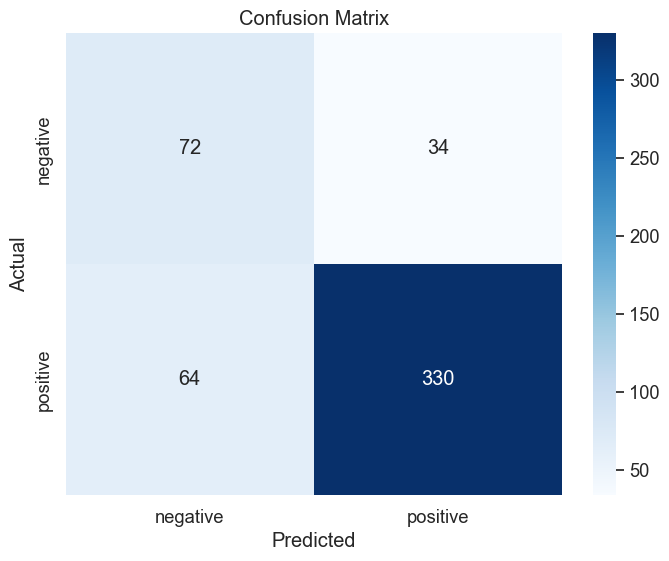

Accuracy: 0.804
Precision: 0.8266308985132516
Recall: 0.804
F1-score: 0.8122701323622408


In [34]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

actual = Iter['TBLabel']
predicted = summary_df['TBLabel']

cm = confusion_matrix(actual, predicted)
labels =['negative','positive']
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted, average='weighted')
recall = recall_score(actual, predicted, average='weighted')
f1 = f1_score(actual, predicted, average='weighted')
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [41]:
df['scores'] = df['CS'].apply(ast.literal_eval)

def find_max_score(score_list):
    return max(score_list)

df['max_score'] = df['scores'].apply(find_max_score)

average_max_score = df['max_score'].mean()

print("Average of maximum scores:", average_max_score)

Average of maximum scores: 0.5577159598033997


In [63]:
from collections import Counter

def k_words(processed_documents, k=10):
    exclude_chars = {"'", ',', ' '}
    all_words = [word for sublist in processed_documents for word in sublist if word not in exclude_chars]
    word_freq = Counter(all_words)
    top_words = [word for word, _ in word_freq.most_common(k)] 
    return top_words

summary_df['top'] = df['topic_word'].apply(lambda x: k_words(x, k=10))


In [56]:
def evaluate_relevance(summary, topic_keywords):
    relevance_score = 0
    for keyword in topic_keywords:
        if keyword.lower() in summary.lower():
            relevance_score += 1
    normalized_relevance_score = relevance_score / len(topic_keywords)
    return normalized_relevance_score

def evaluate_summary(df_summary):
    
    relevance_scores = []
    for summary, topic_keywords in zip(df_summary['Summary'], df_summary['top']):
        relevance_score = evaluate_relevance(summary, topic_keywords)
        relevance_scores.append(relevance_score)
    df_summary['Relevance Score'] = relevance_scores
    
    return df_summary

In [44]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

In [45]:
def calculate_fluency_score(summary):
    tokens = word_tokenize(summary)
    tagged_tokens = pos_tag(tokens)
    correct_tags = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS',
                    'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH',
                    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
    correct_count = sum(1 for _, tag in tagged_tokens if tag in correct_tags)
    fluency_score = correct_count / len(tokens)
    return fluency_score

In [66]:
summary_df['top']=df['topic_word'].swifter.apply(k_words)
summary_df=evaluate_summary(summary_df)
summary_df['Fluency Score'] = summary_df['Summary'].apply(calculate_fluency_score)

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

In [67]:
summary_df['top'][0]

['shot',
 'movie',
 'game',
 'get',
 'something',
 'like',
 'people',
 'case',
 'walking',
 'island']

In [69]:
fluency=avg(summary_df,'Fluency Score')
relevance=avg(summary_df,'Relevance Score')     
print('Fluency = '+str(fluency))
print('Relevance = '+str(relevance))

Fluency = 0.926642630194109
Relevance = 0.6616000000000001


In [70]:
from rouge_score import rouge_scorer

def calculate_rouge(reference_summary, generated_summary):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_summary, generated_summary)
    
    rouge1_score = [scores['rouge1'].precision, scores['rouge1'].recall, scores['rouge1'].fmeasure]
    rouge2_score = [scores['rouge2'].precision, scores['rouge2'].recall, scores['rouge2'].fmeasure]
    rougeL_score = [scores['rougeL'].precision, scores['rougeL'].recall, scores['rougeL'].fmeasure]
    
    return rouge1_score, rouge2_score, rougeL_score

In [71]:
PR = pd.read_csv('PageRank.csv')
PR=PR.iloc[:500]

In [73]:
import numpy as np

avg_rouge_scores_list = []

for i in range(1, 2):
    print(i,end=' ')
    df_name=summary_df
    df = summary_df
    
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    
    for index, row in df.iterrows():
        reference_summary = str(PR.loc[index, 'Summary'])  
        generated_summary = str(row['Summary']) 
        
        rouge1_score, rouge2_score, rougeL_score = calculate_rouge(reference_summary, generated_summary)
        
        rouge1_scores.append(rouge1_score)
        rouge2_scores.append(rouge2_score)
        rougeL_scores.append(rougeL_score)
    
    
    avg_rouge1_precision = np.mean([score[0] for score in rouge1_scores])
    avg_rouge1_recall = np.mean([score[1] for score in rouge1_scores])
    avg_rouge1_fmeasure = np.mean([score[2] for score in rouge1_scores])
    
    avg_rouge2_precision = np.mean([score[0] for score in rouge2_scores])
    avg_rouge2_recall = np.mean([score[1] for score in rouge2_scores])
    avg_rouge2_fmeasure = np.mean([score[2] for score in rouge2_scores])
    
    avg_rougeL_precision = np.mean([score[0] for score in rougeL_scores])
    avg_rougeL_recall = np.mean([score[1] for score in rougeL_scores])
    avg_rougeL_fmeasure = np.mean([score[2] for score in rougeL_scores])
    
    avg_rouge_scores_list.append({
        'df_name': df_name,
        'avg_rouge1_precision': avg_rouge1_precision,
        'avg_rouge1_recall': avg_rouge1_recall,
        'avg_rouge1_fmeasure': avg_rouge1_fmeasure,
        'avg_rouge2_precision': avg_rouge2_precision,
        'avg_rouge2_recall': avg_rouge2_recall,
        'avg_rouge2_fmeasure': avg_rouge2_fmeasure,
        'avg_rougeL_precision': avg_rougeL_precision,
        'avg_rougeL_recall': avg_rougeL_recall,
        'avg_rougeL_fmeasure': avg_rougeL_fmeasure
    })

for avg_rouge_scores in avg_rouge_scores_list:
    print("Average ROUGE-1 Precision, Recall, F-measure:", [avg_rouge_scores['avg_rouge1_precision'],
                                                            avg_rouge_scores['avg_rouge1_recall'],
                                                            avg_rouge_scores['avg_rouge1_fmeasure']])
    print("Average ROUGE-2 Precision, Recall, F-measure:", [avg_rouge_scores['avg_rouge2_precision'],
                                                            avg_rouge_scores['avg_rouge2_recall'],
                                                            avg_rouge_scores['avg_rouge2_fmeasure']])
    print("Average ROUGE-L Precision, Recall, F-measure:", [avg_rouge_scores['avg_rougeL_precision'],
                                                            avg_rouge_scores['avg_rougeL_recall'],
                                                            avg_rouge_scores['avg_rougeL_fmeasure']])
    print()


1 Average ROUGE-1 Precision, Recall, F-measure: [0.3965241686927993, 0.5860857723489079, 0.4564763403385973]
Average ROUGE-2 Precision, Recall, F-measure: [0.22677344739721003, 0.356329552606436, 0.2680981941894254]
Average ROUGE-L Precision, Recall, F-measure: [0.2554853565736677, 0.3838738375376052, 0.2962400050393862]



In [74]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text.lower()) 
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum()]  
    tokens = [word for word in tokens if word not in stop_words]  
    return ' '.join(tokens)

In [76]:
summary_df['Summary']=summary_df['Summary'].apply(preprocess_text)

In [79]:
summary_df['preprocessed_sentence'] = summary_df['Summary'].apply(preprocess_text)

In [80]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

pipeline = make_pipeline(TfidfVectorizer(), LinearSVC())
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, summary_df['preprocessed_sentence'], summary_df['TBLabel'], cv=cv)
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())


Cross-validation scores: [0.79041916 0.76646707 0.77108434]
Mean accuracy: 0.7759901882981026


In [82]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

pipeline = make_pipeline(TfidfVectorizer(), LinearSVC())
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, summary_df['preprocessed_sentence'], summary_df['TBLabel'], cv=cv)
print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())


Cross-validation scores: [0.756 0.752]
Mean accuracy: 0.754


In [83]:
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, summary_df['preprocessed_sentence'], summary_df['TBLabel'], cv=cv)

print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())


Cross-validation scores: [0.73652695 0.76047904 0.75301205]
Mean accuracy: 0.750006012072241


In [84]:
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, summary_df['preprocessed_sentence'], summary_df['TBLabel'], cv=cv)

print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())


Cross-validation scores: [0.728 0.74 ]
Mean accuracy: 0.734


In [85]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model1 = ('svm', LinearSVC())
model2 = ('nb', MultinomialNB())
model3 = ('lr', LogisticRegression())
model4 = ('rf', RandomForestClassifier())

ensemble_models = [model1, model2, model3, model4]

ensemble_classifier = VotingClassifier(estimators=ensemble_models, voting='hard')

pipeline = make_pipeline(TfidfVectorizer(), ensemble_classifier)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, summary_df['preprocessed_sentence'], summary_df['TBLabel'], cv=cv)

print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())


Cross-validation scores: [0.74850299 0.74251497 0.74096386]
Mean accuracy: 0.743993939831181


In [86]:
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model1 = ('svm', LinearSVC())
model2 = ('nb', MultinomialNB())
model3 = ('lr', LogisticRegression())
model4 = ('rf', RandomForestClassifier())

ensemble_models = [model1, model2, model3, model4]

ensemble_classifier = VotingClassifier(estimators=ensemble_models, voting='hard')

pipeline = make_pipeline(TfidfVectorizer(), ensemble_classifier)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, summary_df['preprocessed_sentence'], summary_df['TBLabel'], cv=cv)

print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", cv_scores.mean())

Cross-validation scores: [0.73652695 0.74850299 0.74698795]
Mean accuracy: 0.7440059639756632


In [87]:
from itertools import combinations

models = [
    ('svm', LinearSVC()),
    ('nb', MultinomialNB()),
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier())
]

best_score = 0
best_combination = None

for i in range(2, 4):
    for model_combination in combinations(models, i):
        model_combination_list = list(model_combination)
        ensemble_classifier = VotingClassifier(estimators=model_combination_list, voting='hard')
        pipeline = make_pipeline(TfidfVectorizer(), ensemble_classifier)
        cv_scores = cross_val_score(pipeline, summary_df['preprocessed_sentence'], summary_df['TBLabel'], cv=cv)     
        mean_accuracy = cv_scores.mean()
        if mean_accuracy > best_score:
            best_score = mean_accuracy
            best_combination = model_combination_list

print("Best combination:", best_combination)
print("Best mean accuracy:", best_score)


Best combination: [('svm', LinearSVC()), ('nb', MultinomialNB())]
Best mean accuracy: 0.7759901882981026


In [89]:
from sklearn.pipeline import Pipeline


best_models = [
    ('svm', LinearSVC()),
    ('nb', MultinomialNB())
]


best_models_list = list(best_models)
ensemble_classifier = VotingClassifier(estimators=best_models_list, voting='hard')
pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('classifier', ensemble_classifier)])
pipeline.fit(summary_df['preprocessed_sentence'], summary_df['TBLabel'])

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier',
                 VotingClassifier(estimators=[('svm', LinearSVC()),
                                              ('nb', MultinomialNB())]))])

In [90]:
new_data = [PR['Summary'][1] ]
predicted_label = pipeline.predict(new_data)[0]  
print("Predicted label for the new data:", predicted_label)

Predicted label for the new data: postive


In [91]:
PR['Summary'][1]

'<br /><br />One of the best parts of the film is the set  One of the best visual effects in the film is at the end where Andrew and Dave suddenly discover their powers in this environment - they have the abilities to wish everything away, so what if they can do it the other way around and make things appear?<br /><br />"Nothing" is a bright and well-lit movie, it really helps promoting the idea of them probably being dead (this is in fact one of their theories), but "Nothing" is a comedy and it slowly destroys its own theory  He talks about him and André Bijelic having been room-mates at a time and they both were in this extremely dull room with no hope of getting out, "Nothing" could very well be the screened version of the origin of the Cube story, and to that end, it\'s almost like one of the Cube prequels <br /><br />What can I say? I enjoyed "Nothing", it is a great movie and the different parts of the movie are extremely well-made with tons of intelligent ideas, still I feel the

In [92]:
import numpy as np

PR['Summary'] = PR['Summary'].fillna('')
predicted_labels = []
for summary in PR['Summary']:
    predicted_label = pipeline.predict([summary])[0]
    predicted_labels.append(predicted_label)

PR['Predicted_Label'] = predicted_labels

In [93]:
PR.head(2)

,Unnamed: 0,Summary,Predicted_Label
0,0,"Okay, so I'm not a big video game buff, but wa...",postive
1,1,<br /><br />One of the best parts of the film ...,postive


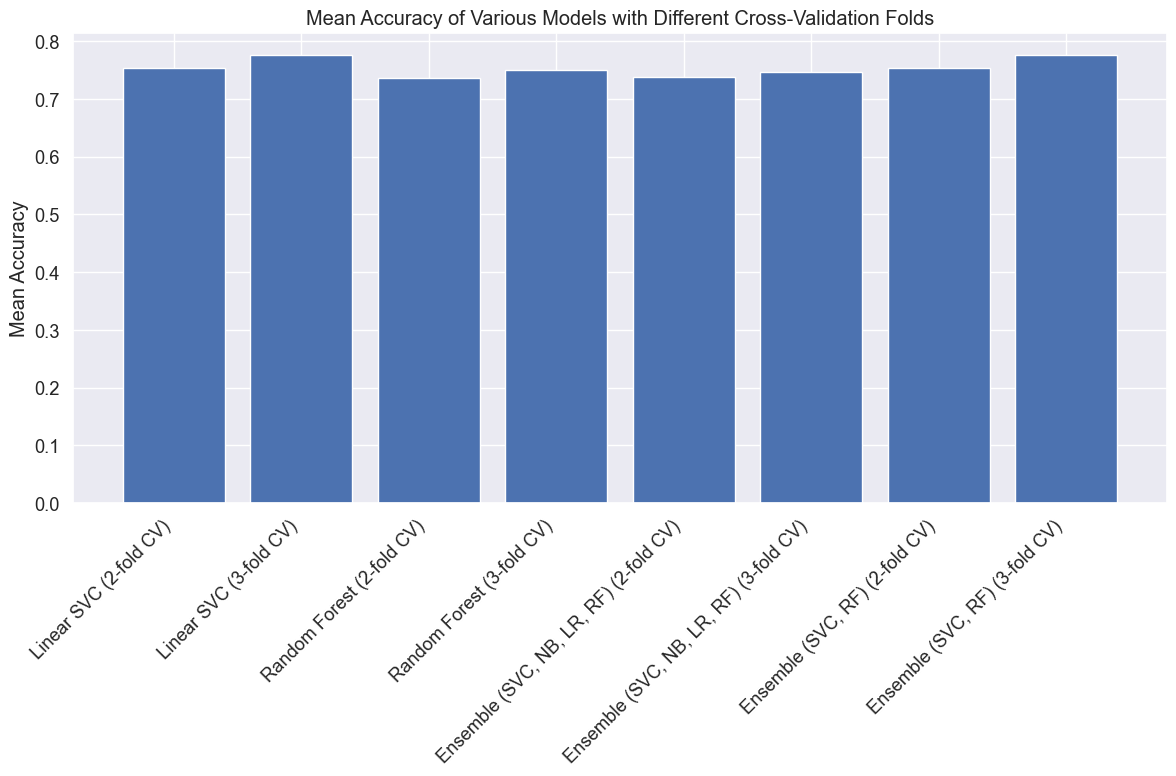

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

models = {
    "Linear SVC": LinearSVC(),
    "Random Forest": RandomForestClassifier(),
    "Ensemble (SVC, NB, LR, RF)": VotingClassifier(
        estimators=[
            ('svc', LinearSVC()),
            ('nb', MultinomialNB()),
            ('lr', LogisticRegression()),
            ('rf', RandomForestClassifier())
        ],
        voting='hard'
    ),
    "Ensemble (SVC, RF)": VotingClassifier(
        estimators=[
            ('svc', LinearSVC()),
            ('rf', RandomForestClassifier())
        ],
        voting='hard'
    )
}

folds = [2, 3]

mean_accuracies = {}

for model_name, model in models.items():
    for fold in folds:
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('classifier', model)
        ])
        cv = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)
        cv_scores = cross_val_score(pipeline, summary_df['preprocessed_sentence'], summary_df['TBLabel'], cv=cv)
        mean_accuracy = np.mean(cv_scores)
        mean_accuracies[(model_name, fold)] = mean_accuracy

fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(models) * len(folds))
labels = [f"{model_name} ({fold}-fold CV)" for model_name, fold in mean_accuracies.keys()]
heights = mean_accuracies.values()
ax.bar(x, heights, tick_label=labels)
ax.set_ylabel('Mean Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_title('Mean Accuracy of Various Models with Different Cross-Validation Folds')
plt.tight_layout()
plt.show()
